In [51]:
import os
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from hydroeval import nse, kge, pbias

from fancyimpute import IterativeImputer as MICE
from fancyimpute import NuclearNormMinimization, SoftImpute

import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, BatchNormalization, ConvLSTM2D, Bidirectional, Flatten
from keras.callbacks import ReduceLROnPlateau
from keras import backend

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
pip install hydroeval

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [52]:
def get_grdc(grdc_no):
    data_date_month = []
    data_date_common = []
    data_value = []
    f = open("Europe/" + grdc_no + "_Q_Day.Cmd.txt", "rb")
    for i in f:
        i = str(i)[2:-5]
        if "#" in i:
            continue
        if "YYYY" in i:
            continue
        temp = [i.strip() for i in i.split(";")]
        date_temp = temp[0].split("-")
        date_temp = [i.strip() for i in temp[0].split("-")]
        data_date_month.append(int(date_temp[1]))
        data_date_common.append(date_temp[0] + "-" + date_temp[1] + "-" + date_temp[2])
        data_value.append(round(float(temp[2]), 3))
    df_temp = pd.DataFrame(list(zip(data_date_month, data_value, data_date_common)),
                               columns =["Month", "Value", "Date"])
    df_temp = df_temp.set_index('Date')
    df_temp = df_temp[df_temp["Month"] != 0]
    df_temp.sort_index()
    df_index = df_temp.index
    df_temp.replace(-999.0, np.nan, inplace=True)
    
    return df_temp

In [53]:
def get_data(f):
    
    value = []
    common = []
    
    grdc_no = ""
    latitude = ""
    longitude = ""
    
    for i in f:
        
        i = str(i)[2:-5]
        
        if "GRDC-No" in i:
            grdc_no = i.split(":")[1].strip()
            continue
        elif "Latitude" in i:
            latitude = i.split(":")[1].strip()
            continue
        elif "Longitude" in i:
            longitude = i.split(":")[1].strip()
            continue
        elif "YYYY" in i:
            continue
        elif "#" in i:
            continue

        temp = [i.strip() for i in i.split(";")]
        date_temp = temp[0].split("-")
        date_temp = [i.strip() for i in temp[0].split("-")]
        common.append(date_temp[0] + "-" + date_temp[1] + "-" + date_temp[2])
        value.append(round(float(temp[2]), 3))
        
    return value, common, grdc_no, latitude, longitude

In [54]:
def merged(x, x_ncdc):
    
    x = x.set_index('Date')
    x.sort_index()
    x_ncdc = x_ncdc.set_index('DATE')
    x_ncdc.sort_index()
    
    x_first = x.index[0] if x.index[0] > x_ncdc.index[0] else x_ncdc.index[0]
    x_last = x.index[-1] if x.index[-1] < x_ncdc.index[-1] else x_ncdc.index[-1]
    merged = pd.concat([x, x_ncdc], axis=1, sort=True)
    to_delete = []
    for i, r in merged.iterrows():
        if i < x_first or i > x_last:
            to_delete.append(i)
            
    merged = merged.drop(to_delete)
    
    return merged

In [55]:
all_data = {}

for filename in os.listdir("Europe/"):

    f = open("Europe/" + filename, "rb")
    f2 = pd.read_csv("NCDC/" + filename[:7] + ".csv")

    value, common, grdc_no, latitude, longitude = get_data(f)
    f.close()

    df_temp = pd.DataFrame(list(zip(value, common)), columns =["Value", "Date"])
    df_temp = merged(df_temp, f2)
    df2 = df_temp["Value"]
    df2 = df2.replace(-999.0, np.nan)
    df2 = df2.fillna(df2.mean())
    first_index = df_temp["LONGITUDE"].first_valid_index()
    temp_dict = {
        "GRDC_latitude": latitude,
        "GRDC_longitude": longitude,
        "NCDC_latitude": df_temp["LATITUDE"][first_index],
        "NCDC_longitude": df_temp["LONGITUDE"][first_index],
        "Elevation": df_temp["ELEVATION"][first_index]
    }
    cols = list(df_temp.columns)
    cols_to_keep = []
    for i in cols:
        if len(i) == 4 and i != "NAME":
            cols_to_keep.append(i)
            cols.remove(i)
    df_temp.drop(columns=cols, inplace=True)
    df_temp.sort_index()
    df_index = df_temp.index
    soft_impute = SoftImpute(max_iters=300, verbose=False)
    df_temp = soft_impute.fit_transform(df_temp)
    df_temp = pd.DataFrame(data=df_temp, columns=cols_to_keep)
    if "PRCP" in cols_to_keep:
        df_temp[df_temp["PRCP"] < 0] = 0
    if "SNWD" in cols_to_keep:
        df_temp[df_temp["SNWD"] < 0] = 0
    df_temp["Date"] = df_index
    df_temp = df_temp.set_index(["Date"])
    df_temp["t-1"] = df2.shift(1)
    df_temp = df_temp.replace(np.nan, 0)
    temp_dict["data_x"] = df_temp
    temp_dict["data_y"] = df2
    all_data[grdc_no] = temp_dict

/software/jupyterhub/env/jupyterhub-user/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
all_data

{'6233250': {'GRDC_latitude': '56.1',
  'GRDC_longitude': '14.12',
  'NCDC_latitude': 51.7667,
  'NCDC_longitude': -1.2667,
  'Elevation': 63.0,
  'data_x':             PRCP  TMAX  TMIN    t-1
  Date                               
  1908-01-01  0.00  33.0  31.0   0.00
  1908-01-02  0.00  32.0  26.0  30.00
  1908-01-03  0.00  38.0  21.0  29.00
  1908-01-04  0.00  27.0  21.0  29.00
  1908-01-05  0.00  49.0  21.0  28.00
  ...          ...   ...   ...    ...
  2018-09-22  0.56  58.0  50.0   8.18
  2018-09-23  0.04  61.0  46.0   2.00
  2018-09-24  0.00  64.0  39.0   2.00
  2018-09-25  0.00  72.0  37.0   2.00
  2018-09-26  0.00  74.0  44.0  14.90
  
  [40447 rows x 4 columns],
  'data_y': 1908-01-01    30.0
  1908-01-02    29.0
  1908-01-03    29.0
  1908-01-04    28.0
  1908-01-05    28.0
                ... 
  2018-09-22     2.0
  2018-09-23     2.0
  2018-09-24     2.0
  2018-09-25    14.9
  2018-09-26    14.6
  Name: Value, Length: 40447, dtype: float64},
 '6233780': {'GRDC_latitude': '6

In [56]:
pickle.dump(all_data, open("save_soft_impute.p", "wb"))

In [57]:
all_data = pickle.load(open( "save_soft_impute.p", "rb" ))

In [58]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [59]:
new_data_x = all_data["6233250"]["data_x"]
new_data_y = all_data["6233250"]["data_y"]
new_data_y2 = np.asarray(new_data_y).reshape((-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
new_data_x2 = scaler.fit_transform(new_data_x)
new_data_y2 = scaler.fit_transform(new_data_y2)
dataset = np.hstack((new_data_x2, new_data_y2))
X, y = split_sequences(dataset, 3)
# X_train, X_test, y_train, y_test = train_test_split(new_data_x, new_data_y, test_size = 0.20)
train_size = round(0.8*new_data_x2.shape[0])
X_train = new_data_x2[:train_size]
y_train = new_data_y2[:train_size]
X_test = new_data_x2[train_size:]
y_test = new_data_y2[train_size:]
X_train2 = np.asarray(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
y_train2 = np.asarray(y_train)
X_test2 = np.asarray(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
y_test2 = np.asarray(y_test)
# X_train3 = X_train.reshape(X_train.shape[0], 2, 1, 3, X_train.shape[1])

model = Sequential()
# model.add(BatchNormalization(input_shape = (None, None, None, 1)))
# model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu'))
#                      ,input_shape=(2, 1, 3, X_train.shape[1])))
# model.add(Flatten())
# model.add(Bidirectional(LSTM(8, activation='relu'), input_shape=[X_train2.shape[1], X_train2.shape[2]]))
model.add(LSTM(8, input_shape=[X_train2.shape[1], X_train2.shape[2]]))
# model.add(SimpleRNN(8, input_shape=[X_train2.shape[1], X_train2.shape[2]]))
# model.add(Dense(16))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [60]:
new_data_x.shape

(40447, 4)

In [61]:
history = model.fit(X_train2, y_train2 ,epochs = 50)

Epoch 1/50
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0402 - root_mean_squared_error: 0.0706
Epoch 2/50
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0129 - root_mean_squared_error: 0.0212
Epoch 3/50
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0123 - root_mean_squared_error: 0.0209
Epoch 4/50
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0122 - root_mean_squared_error: 0.0209
Epoch 5/50
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0121 - root_mean_squared_error: 0.0209
Epoch 6/50
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0121 - root_mean_squared_error: 0.0208
Epoch 7/50
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0121 - root_mean_squared_error: 0.0208
Epoch 8/50
1012/1012 [==============================] - 2s 2ms/step - loss: 0.0121 - root_mean_squared_error: 0.0209
Epoch 9/50
1012/1012 [==============================] - 2s 2ms/s

In [62]:
temp = model.evaluate(X_test2,y_test2)
print("Mean Absolute Error - " , temp[0])
print("Root Mean Squared Error - " , temp[1]*100)

253/253 [==============================] - 0s 932us/step - loss: 0.0193 - root_mean_squared_error: 0.0277
Mean Absolute Error -  0.01933126337826252
Root Mean Squared Error -  2.773474343121052


In [63]:
results_train = model.predict(X_train2)
results_test = model.predict(X_test2)

In [64]:
# 2969101
# 2969100
station = "6233250"
test_new_x = np.asarray(all_data[station]["data_x"])
test_new_y = np.asarray(all_data[station]["data_y"])

test_new_y = np.asarray(test_new_y).reshape((-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_new_x = scaler.fit_transform(test_new_x)
test_new_y = scaler.fit_transform(test_new_y)
test_new_x = test_new_x.reshape((test_new_x.shape[0], test_new_x.shape[1], 1))

results = model.predict(test_new_x)

In [65]:
results

array([[0.00131947],
       [0.11300266],
       [0.10768834],
       ...,
       [0.008175  ],
       [0.00719911],
       [0.05515945]], dtype=float32)

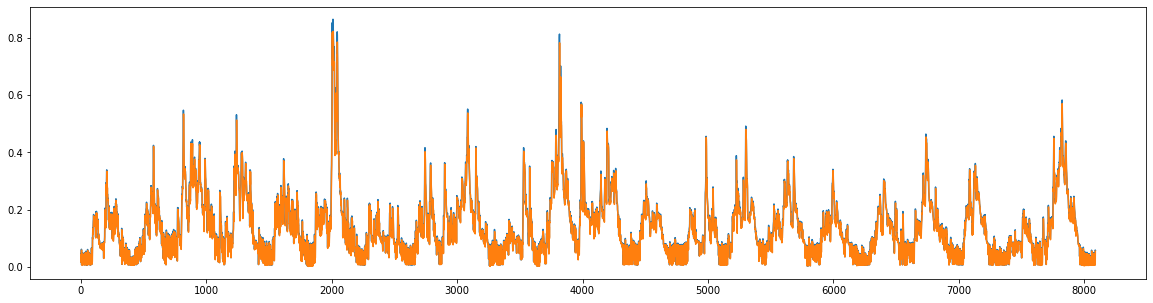

In [66]:
plt.figure(figsize=(20,5))
plt.plot([i for i in range(len(y_test))], y_test)
# plt.plot([i for i in range(len(test_new_y))], test_new_y)
plt.plot([i for i in range(len(results_test))], results_test)
plt.show()

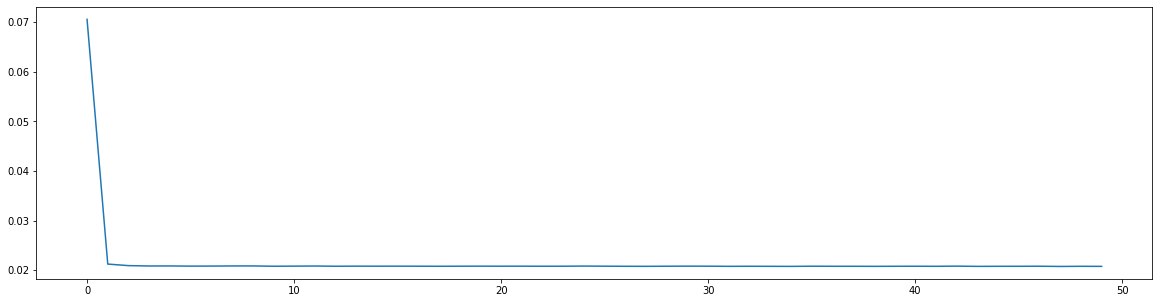

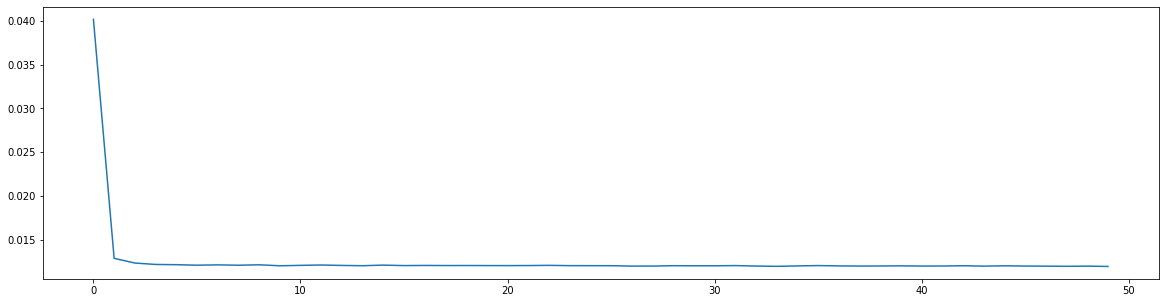

In [67]:
plt.figure(figsize=(20,5))
plt.plot(history.history["root_mean_squared_error"])
plt.figure(figsize=(20,5))
plt.plot(history.history["loss"])
plt.show()

In [68]:
x_labels = []
for i in range(0,len(new_data_y[train_size:]), 200):
#     print(i)
    x_labels.append(new_data_y.index[i])
    
print(len(x_labels))

41


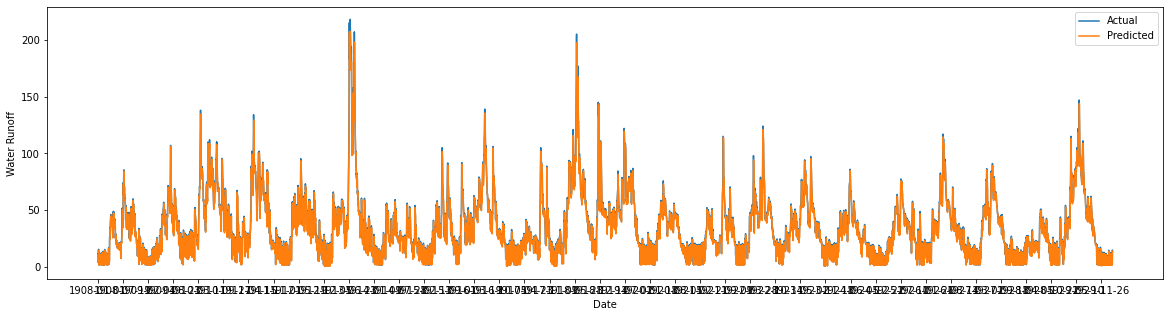

In [69]:
trainPredict = scaler.inverse_transform(results_train)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(results_test)
testY = scaler.inverse_transform(y_test)
# calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
# trainPredictPlot = np.empty_like(dataset)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()
plt.figure(figsize=(20,5))
# plt.plot([i for i in range(len(testY[:200]))], testY[:200])
# plt.plot([i for i in range(len(testPredict[:200]))], testPredict[:200])
# Y_test = y_test.index
plt.plot(testY, label="Actual")
plt.plot(testPredict, label="Predicted")
plt.xticks(range(0,len(new_data_y[train_size:]), 200), x_labels)
plt.legend(['Actual','Predicted'])
plt.xlabel("Date")
plt.ylabel("Water Runoff")
plt.show()

In [70]:
testY = testY.reshape(-1)
testPredict = testPredict.reshape(-1)

In [71]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import r2_score

In [72]:
nmi_score = normalized_mutual_info_score(testY, testPredict)

In [73]:
nmi_score

0.8531512977778158

In [74]:
r_score = r2_score(testY, testPredict)

In [75]:
r_score

0.9327968672248004

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
regr = RandomForestRegressor(criterion="mae")

In [78]:
y_train_random_forest = y_train.reshape(-1)
y_test_random_forest = y_test.reshape(-1)

In [79]:
regr.fit(X_train, y_train_random_forest)

RandomForestRegressor(criterion='mae')

In [80]:
random_f = regr.predict(X_test)

In [81]:
random_f = random_f.reshape(-1,1)

In [82]:
testPredict_random = scaler.inverse_transform(random_f)

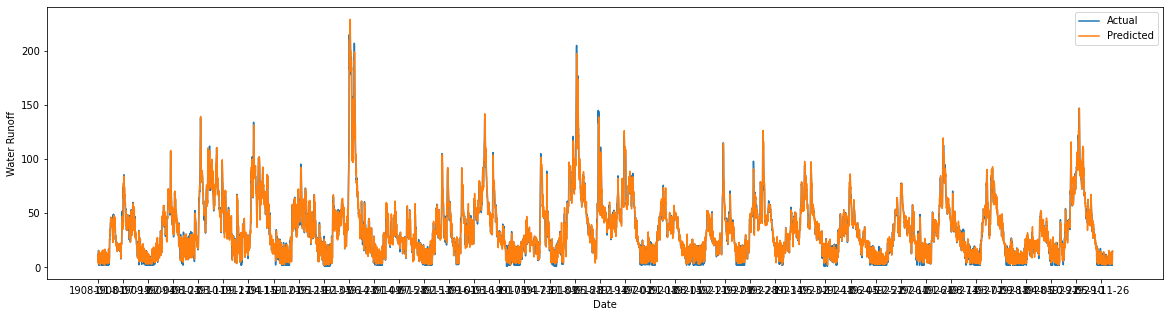

In [83]:
plt.figure(figsize=(20,5))
plt.plot(testY, label="Actual")
plt.plot(testPredict_random, label="Predicted")
plt.xticks(range(0,len(new_data_y[train_size:]), 200), x_labels)
plt.legend(['Actual','Predicted'])
plt.xlabel("Date")
plt.ylabel("Water Runoff")
plt.show()

In [84]:
testPredict_random = testPredict_random.reshape(-1)

In [85]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [86]:
mae_random_forest = mean_absolute_error(testY, testPredict_random)
rmse_random_forest = mean_squared_error(testY, testPredict_random, squared=False)
nmi_random_forest = normalized_mutual_info_score(testY, testPredict_random)
r_random_forest = r2_score(testY, testPredict_random)

In [87]:
r_random_forest

0.9314261372136148

In [88]:
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor

In [89]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train_random_forest)

Ridge()

In [90]:
random_f = clf.predict(X_test)

In [91]:
random_f = random_f.reshape(-1,1)
testPredict_random = scaler.inverse_transform(random_f)

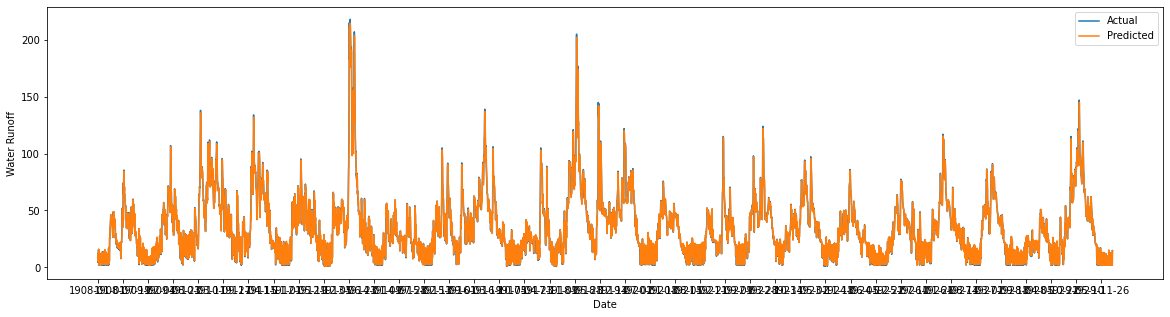

In [92]:
plt.figure(figsize=(20,5))
plt.plot(testY, label="Actual")
plt.plot(testPredict_random, label="Predicted")
plt.xticks(range(0,len(new_data_y[train_size:]), 200), x_labels)
plt.legend(['Actual','Predicted'])
plt.xlabel("Date")
plt.ylabel("Water Runoff")
plt.show()

In [93]:
from sklearn.svm import SVR

In [49]:
f = open("metrics.csv", "w")
f.write("Station_id,Latitude,Longitude,NMI,R_Squared,MAE,RMSE,NSE,pBias")
f.write("\n")
for i in all_data:
    test_new_x = np.asarray(all_data[i]["data_x"])
    test_new_y = np.asarray(all_data[i]["data_y"])

    test_new_y = np.asarray(test_new_y).reshape((-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_new_x = scaler.fit_transform(test_new_x)
    test_new_y = scaler.fit_transform(test_new_y)
    test_new_x = test_new_x.reshape((test_new_x.shape[0], test_new_x.shape[1], 1))
    
    results = model.predict(test_new_x)
    
    testY = test_new_y.reshape(-1)
    testPredict = results.reshape(-1)
    
    nmi_score = normalized_mutual_info_score(testY, testPredict)
    r_score = r2_score(testY, testPredict)
    mae = mean_absolute_error(testY, testPredict)
    rmse = mean_squared_error(testY, testPredict, squared=False)
    nse_ = nse(testPredict, testY)
#     kge_ = kge(testPredict, testY)
    pbias_ = pbias(testPredict, testY)
    
    f.write(str(i)+","+str(all_data[i]["GRDC_latitude"])+","+str(all_data[i]["GRDC_longitude"])+","+str(nmi_score)+","+str(r_score)+","+str(mae)+","+str(rmse)+","+str(nse_)+","+str(pbias_))
    f.write("\n")
    
#     plt.figure(figsize=(20,5))
#     plt.plot([i for i in range(len(test_new_y))], test_new_y)
#     # plt.plot([i for i in range(len(test_new_y))], test_new_y)
#     plt.plot([i for i in range(len(results))], results)
#     plt.show()
    
f.close()

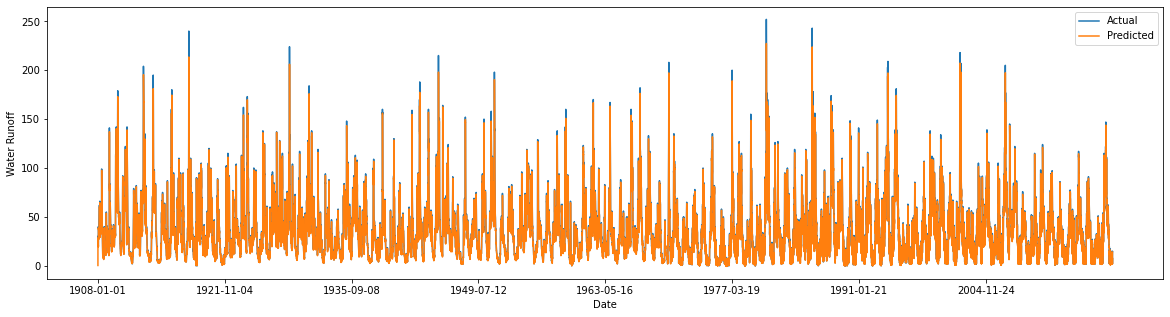

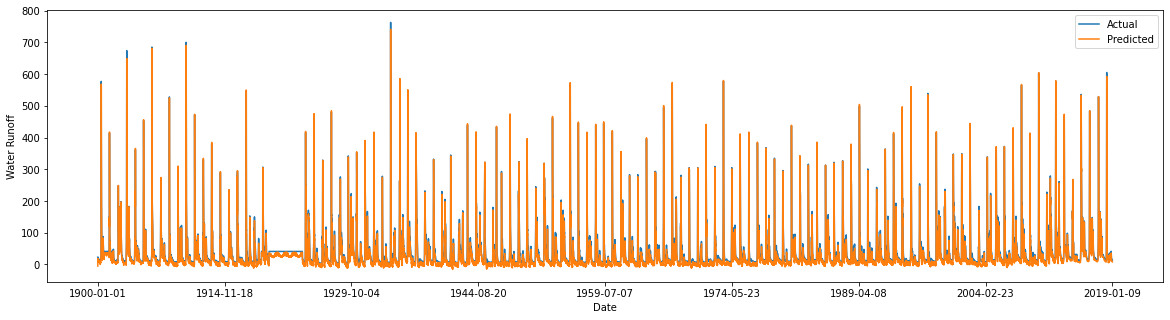

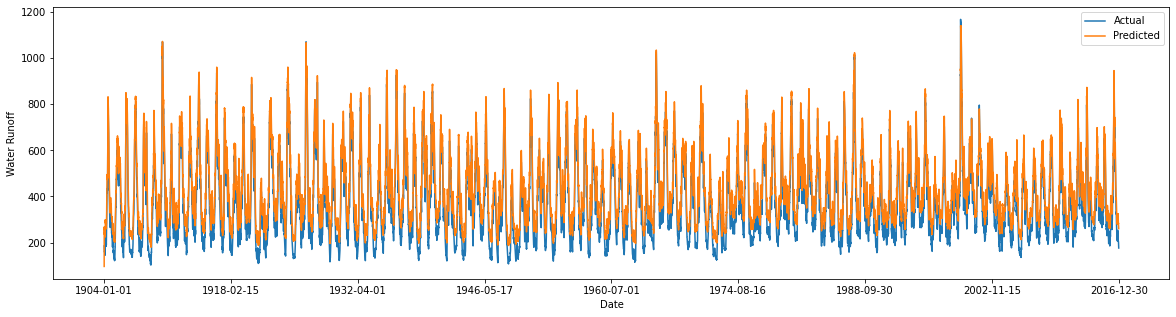

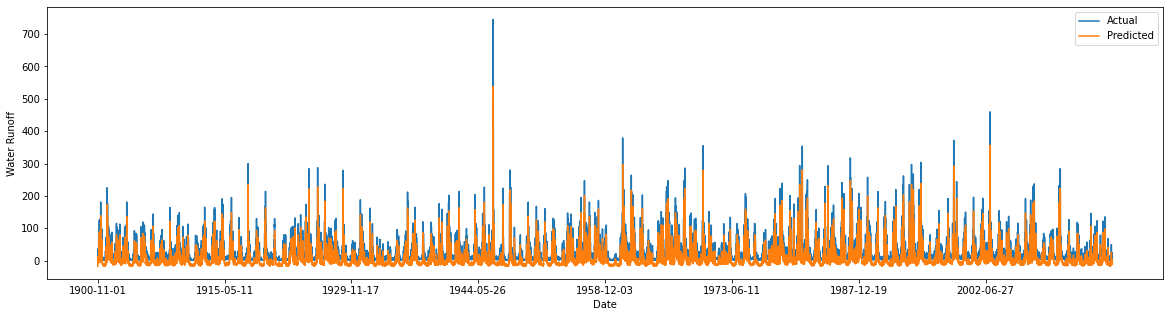

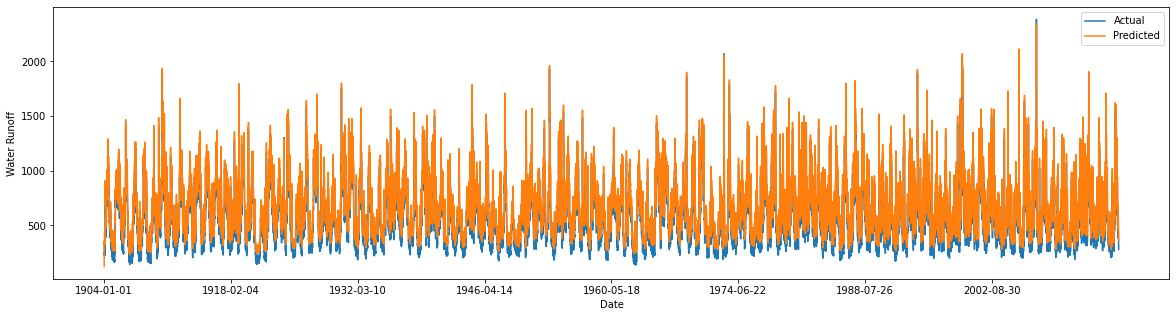

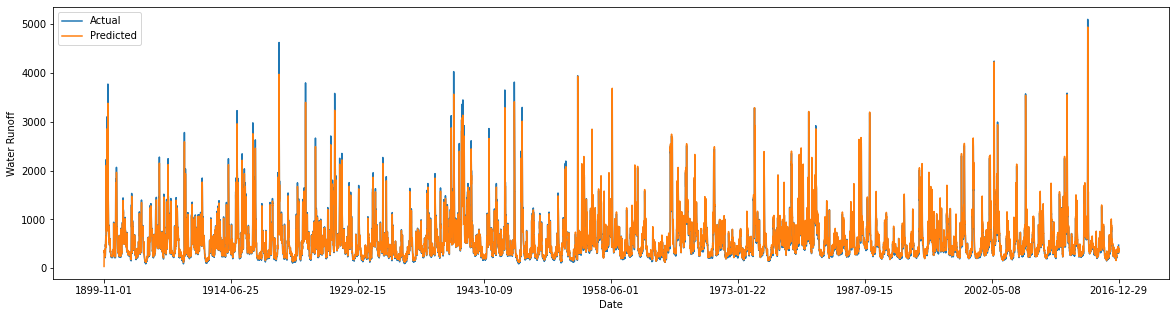

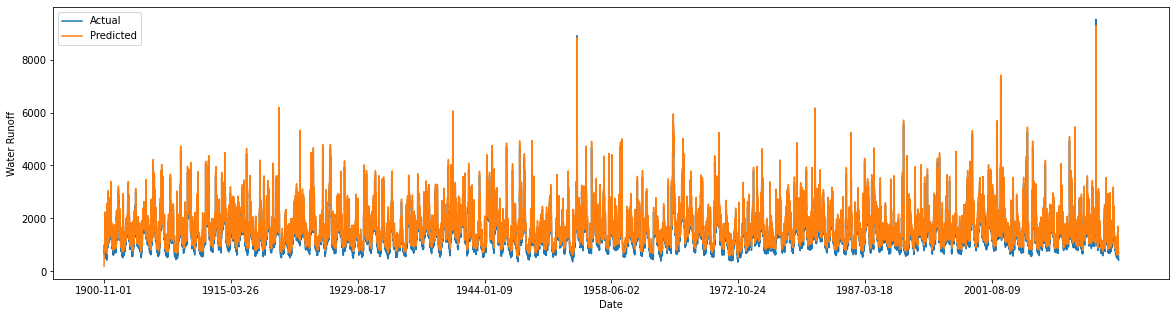

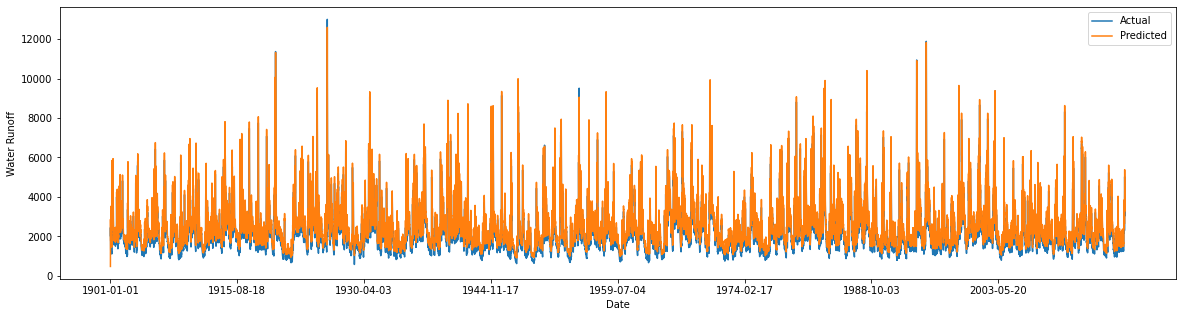

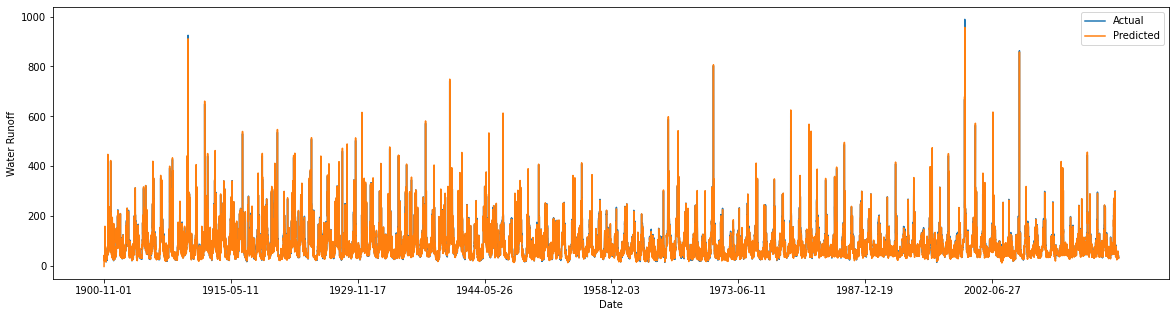

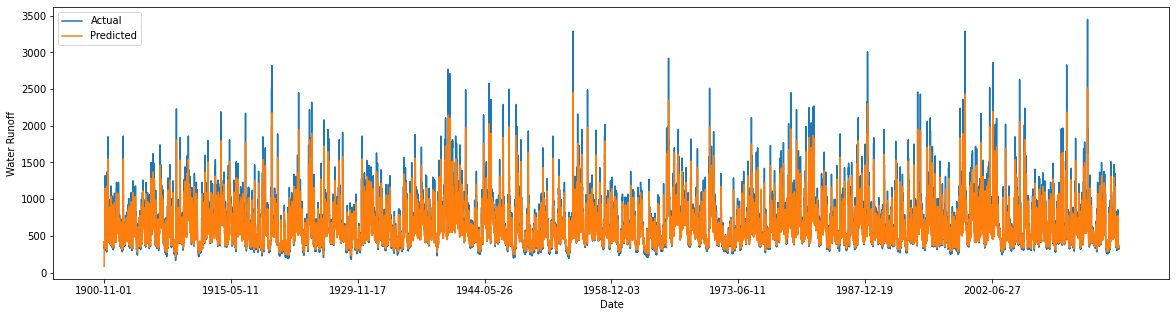

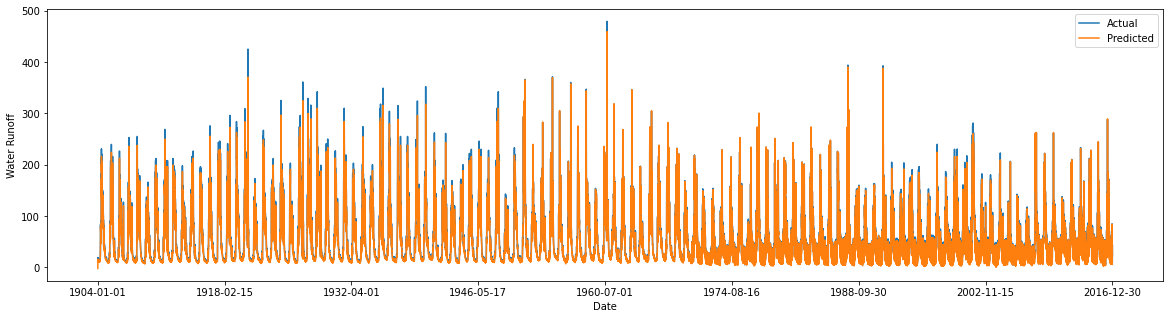

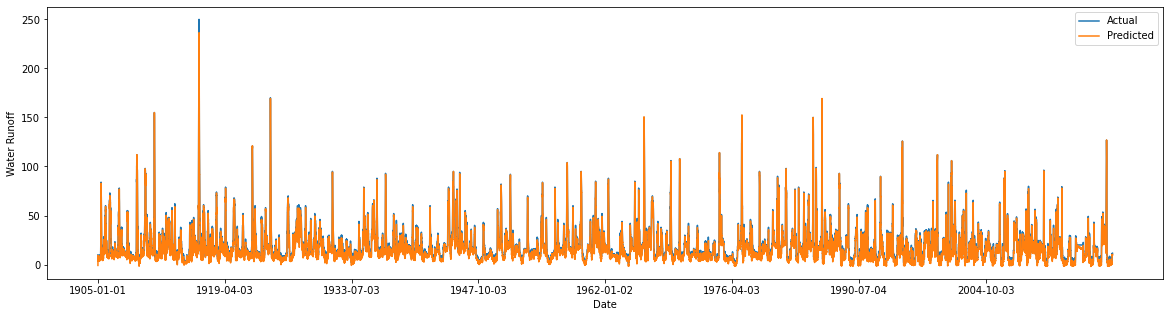

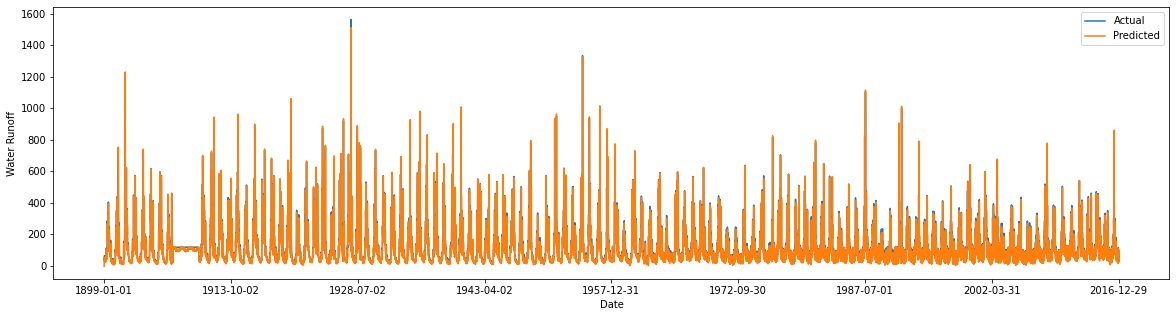

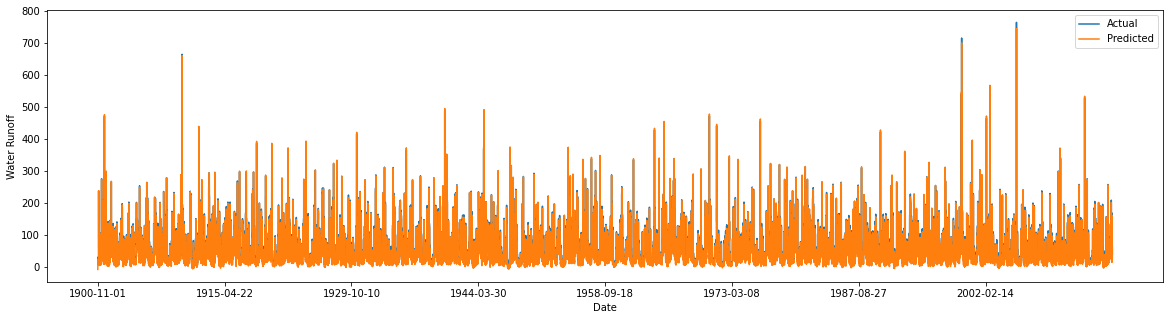

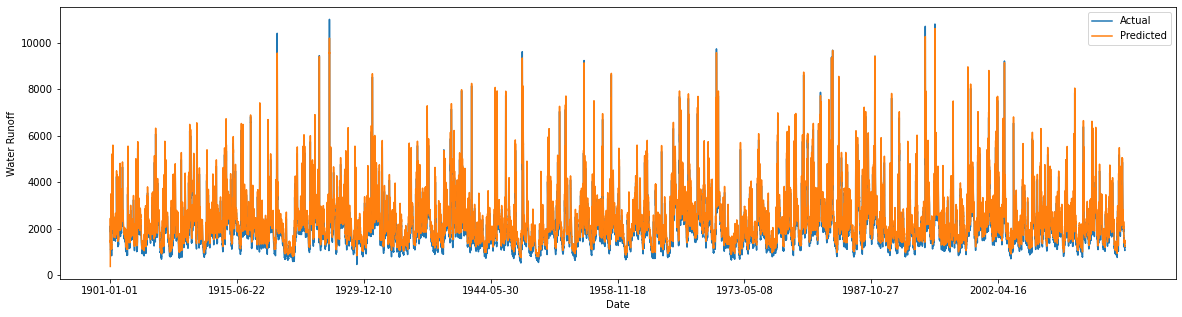

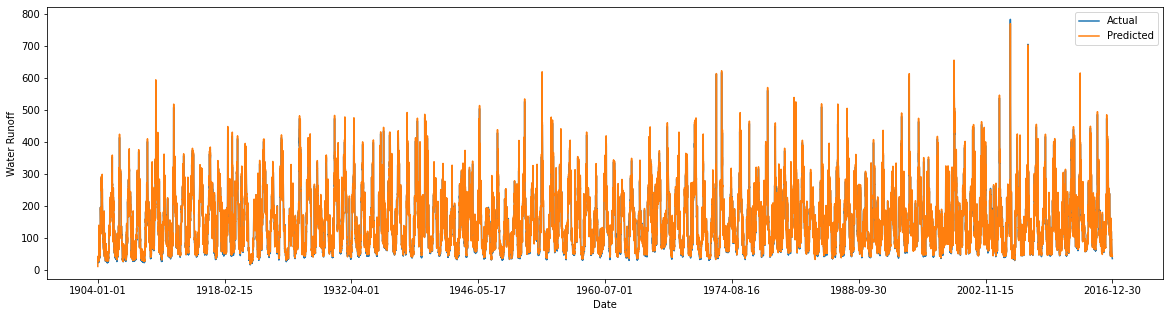

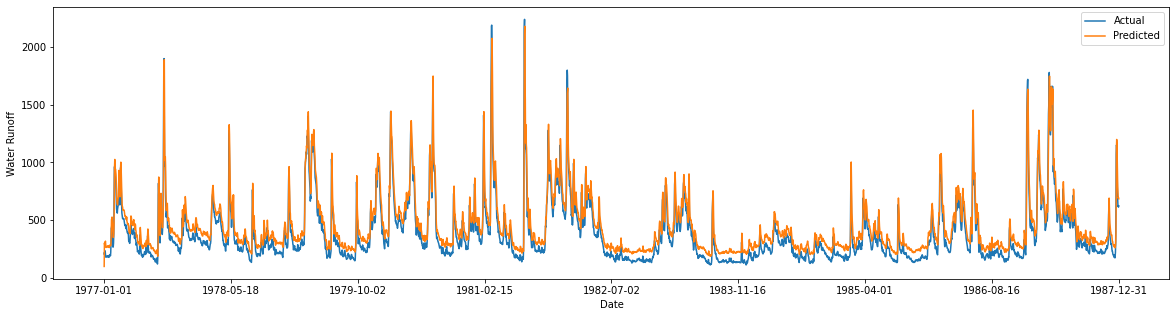

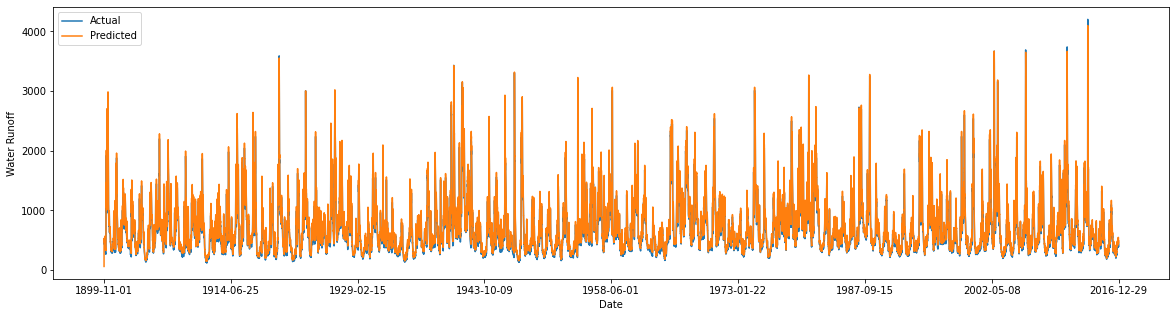

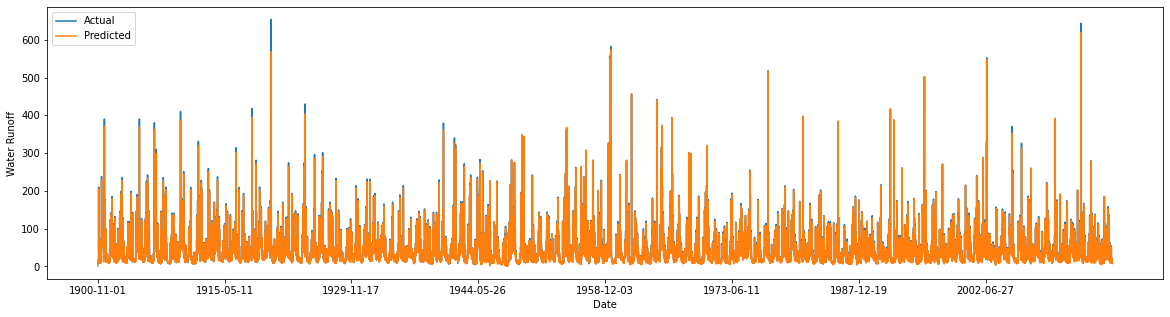

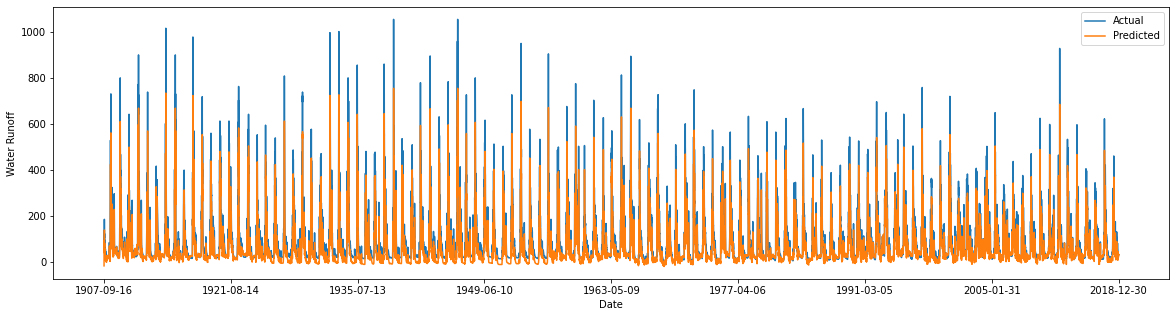

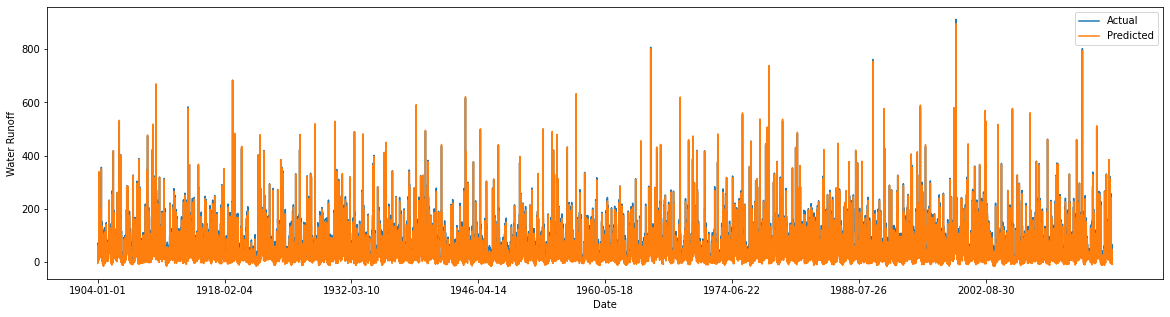

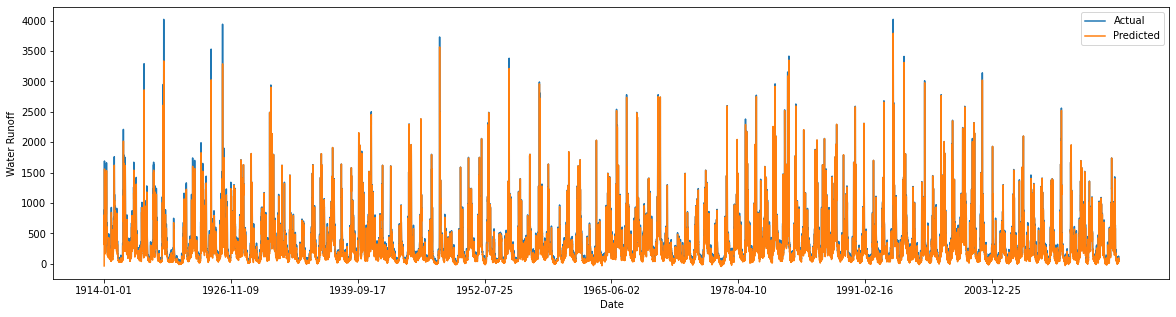

In [96]:
f = open("metrics.csv", "w")
f.write("Station_id,Latitude,Longitude,NMI,R_Squared,MAE,RMSE,NSE,pBias")
f.write("\n")
for i in all_data:
    test_new_x = np.asarray(all_data[i]["data_x"])
    test_new_y = np.asarray(all_data[i]["data_y"])
    temp = len(test_new_y)
    temp2 = round(temp/8)
    x_labels = []
#     for j in range(0,len(test_new_y), 1000):
    for j in range(0, temp, temp2):
    #     print(i)
        x_labels.append(all_data[i]["data_y"].index[j])

    test_new_y = np.asarray(test_new_y).reshape((-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_new_x = scaler.fit_transform(test_new_x)
    test_new_y = scaler.fit_transform(test_new_y)
    test_new_x = test_new_x.reshape((test_new_x.shape[0], test_new_x.shape[1], 1))
    
    results = model.predict(test_new_x)
    
    results = scaler.inverse_transform(results)
    test_new_y = scaler.inverse_transform(test_new_y)
    
    testY = test_new_y.reshape(-1)
    testPredict = results.reshape(-1)
    
    nmi_score = normalized_mutual_info_score(testY, testPredict)
    r_score = r2_score(testY, testPredict)
    mae = mean_absolute_error(testY, testPredict)
    rmse = mean_squared_error(testY, testPredict, squared=False)
    nse_ = nse(testPredict, testY)
#     kge_ = kge(testPredict, testY)
    pbias_ = pbias(testPredict, testY)
    
    f.write(str(i)+","+str(all_data[i]["GRDC_latitude"])+","+str(all_data[i]["GRDC_latitude"])+","+str(nmi_score)+","+str(r_score)+","+str(mae)+","+str(rmse)+","+str(nse_)+","+str(pbias_))
    f.write("\n")
    
    plt.figure(figsize=(20,5))
#     plt.plot([i for i in range(len(test_new_y))], test_new_y)
    # plt.plot([i for i in range(len(test_new_y))], test_new_y)
#     plt.plot([i for i in range(len(results))], results)
    plt.plot(testY, label="Actual")
    plt.plot(testPredict, label="Predicted")
    plt.xticks(range(0,temp, temp2), x_labels)
    plt.legend(['Actual','Predicted'])
    plt.xlabel("Date")
    plt.ylabel("Water Runoff")
    plt.savefig("NCDC/" + i + ".png")
    plt.show()
    
f.close()

In [51]:
temp = nse(testPredict, testY)

In [52]:
temp

0.8710082169502257